# NSE `Nifty 50 ` Data for RNN Model

In [2]:
import os
import pandas as pd
import nselib
from nselib import capital_market

def fetch_and_save_nse_data(symbol, start_date='01-01-2021', end_date='30-09-2025', save_path=None):
    # Fetch data
    data = capital_market.price_volume_data(symbol=symbol, from_date=start_date, to_date=end_date)
    
    # Filter EQUITY SERIES only
    data_eq = data[data['Series'] == 'EQ']
    
    # Select relevant columns
    cols = ['Symbol', 'Series', 'Date', 'PrevClose', 'OpenPrice', 'HighPrice',
            'LowPrice', 'ClosePrice', 'TotalTradedQuantity']
    data_eq = data_eq[cols]
    
    # Convert columns to float
    n_cols = ['PrevClose', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice']
    for col in n_cols:
        data_eq[col] = data_eq[col].astype(float)
    
    # Convert volume (remove commas and convert to numeric)
    data_eq['Volume'] = pd.to_numeric(data_eq['TotalTradedQuantity'].str.replace(',', ''), errors='coerce').astype('Int64')
    
    # Convert Date column to datetime
    data_eq['Date'] = pd.to_datetime(data_eq['Date'], format='%d-%b-%Y', errors='coerce')
    
    # Drop the original TotalTradedQuantity column
    data_eq = data_eq.drop(columns='TotalTradedQuantity', axis=1)
    
    print(f'Data preprocessing (`Data Types`) conversion is done...')

    # Select only Date, ClosePrice, Volume
    df = data_eq[['Date', 'ClosePrice']]
    
    # Set Date as index
    df.set_index('Date', inplace=True)
    
    # Set default save path if not provided
    if save_path is None:
        # Create folder if not exists
        os.makedirs('Data', exist_ok=True)
        save_path = f'Data/{symbol}_raw.csv'
    
    data_eq.to_csv(save_path, index=False, header=True)
    print(f'Data for {symbol} saved to {save_path}!')

# Example usage:
# fetch_and_save_nse_data('SBIN', '02-09-2025', '06-09-2025')


#### We can easily download and retirve data from 2021 til today from NSE website using the nselib python packages desinged for the same....Credits to `Ruchi Tanmay` for this wesome package

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.dates as mdates

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import MinMaxScaler
# import keras


import warnings
warnings.filterwarnings('ignore')




In [10]:
data_eq = pd.read_csv(r'Data\\raw.csv')
# Print the shape of the data
print(f'Data shape: {data_eq.shape}')

Data shape: (1178, 9)


In [11]:
data_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Symbol               1178 non-null   object 
 1   Series               1178 non-null   object 
 2   Date                 1178 non-null   object 
 3   PrevClose            1178 non-null   float64
 4   OpenPrice            1178 non-null   float64
 5   HighPrice            1178 non-null   float64
 6   LowPrice             1178 non-null   float64
 7   ClosePrice           1178 non-null   float64
 8   TotalTradedQuantity  1178 non-null   object 
dtypes: float64(5), object(4)
memory usage: 83.0+ KB


In [12]:
data_eq.isna().sum()

Symbol                 0
Series                 0
Date                   0
PrevClose              0
OpenPrice              0
HighPrice              0
LowPrice               0
ClosePrice             0
TotalTradedQuantity    0
dtype: int64

In [13]:
data_eq.duplicated().sum()

np.int64(0)

In [14]:
data_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
PrevClose,1178.0,608.596986,156.057952,274.95,490.6625,578.325,774.9250,905.65
OpenPrice,1178.0,609.521350,156.176599,271.90,490.1500,579.225,776.6875,897.00
HighPrice,1178.0,615.642530,156.944874,280.00,495.5375,583.300,784.6250,912.00
LowPrice,1178.0,602.695501,155.116413,269.50,484.6625,574.425,765.6250,883.30
ClosePrice,1178.0,609.104202,155.943567,275.65,490.7750,578.450,775.7625,905.65


In [18]:
# df = data_eq[['Date','ClosePrice', 'Volume']]
df = data_eq[['Date','ClosePrice']]
df.set_index('Date', inplace=True)
df

,ClosePrice
Date,
01-Jan-2021,279.40
04-Jan-2021,281.05
05-Jan-2021,281.75
06-Jan-2021,285.05
07-Jan-2021,287.70
...,...
24-Sep-2025,866.20
25-Sep-2025,861.15
26-Sep-2025,856.95


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


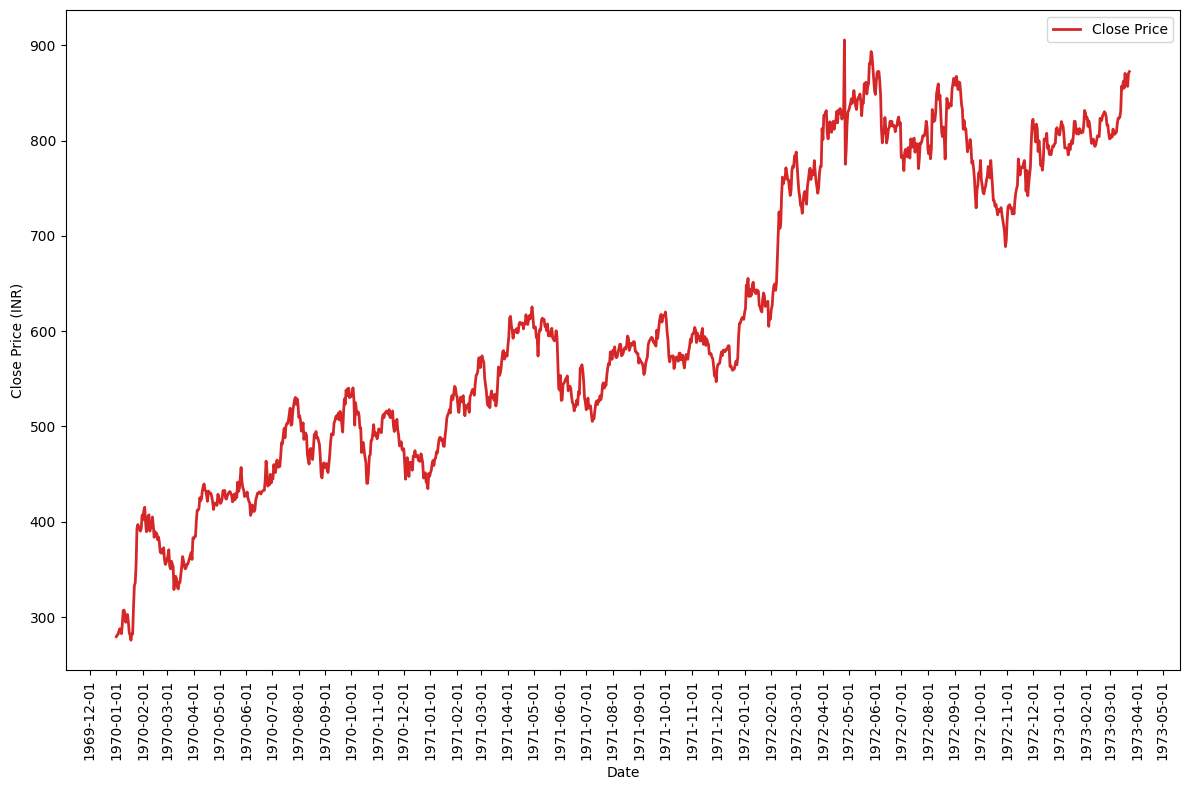

In [17]:
# Plot the SYMBOL
# Assuming 'df' is your DataFrame with a datetime index
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df.index, df['ClosePrice'], label='Close Price', color='tab:red', linewidth=2)

# Set date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set major ticks locator
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.xticks(rotation=90)

plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.tight_layout()
plt.legend()
plt.savefig('Images/ClosePrice.png')
plt.show()


The plot shows a increasing trend in close price for SBIN- Symbol for the last 5 years which is a good sign.

We use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

### Create Features and Target for TimeSeries/Sequential Data

- Split data into Train, Validation and Test set
- Scale the datasets using 'MinMaxScaler` or `StandardScaler`
- Create `look_back` & `future` sequences --- `lookback last 20 days and predict future 5 days`
- Split into Features and Target using `create_multivariate_sequences` custom function
- Build Simple RNN Model 
- Train Model
- Predictions
- Evaluate Performance

In [20]:
def create_multivariate_sequences(data_array, lookback, horizon):
    """
    data_array: numpy array of shape (n_samples, n_features)
    lookback: number of past timesteps (e.g. 60)
    horizon: number of future steps to predict (e.g. 10)
    
    Returns:
      X: shape (num_seq, lookback, n_features)
      y: shape (num_seq, horizon)  # predicting only one target (close price) per future step
    """
    X, y = [], []
    n_samples = data_array.shape[0]
    for i in range(lookback, n_samples - horizon + 1):
        X.append(data_array[i - lookback : i, :])     # last lookback steps, all features
        # For y, we pick the target feature (say column 0 is Close) for next horizon steps
        y.append(data_array[i : i + horizon, 0])      # shape (horizon,)
    return np.array(X), np.array(y)

In [21]:
# Split `df` into Train, Val and Test sets

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f"Length of df : {n} \nNumber of Features: {num_features} \nShape of Xtrain - {train_df.shape} \nShape of Xval - {val_df.shape} \nShape of XTest - {test_df.shape} ")

Length of df : 1178 
Number of Features: 1 
Shape of Xtrain - (824, 1) 
Shape of Xval - (236, 1) 
Shape of XTest - (118, 1) 


In [22]:
# Apply Scaling
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train_df.values)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler,f)

val_scaled = scaler.transform(val_df.values)
test_scaled = scaler.transform(test_df.values)

print('Train, Val and Test dataframes are scaled succesfully...')



Train, Val and Test dataframes are scaled succesfully...


In [23]:
# Create `lookback` and `horizon` variables
lookback = 20 # model look back to last 20 days of data
horizon = 1 # model predicts future values for 5 days

In [24]:
# Create `X` & `y` datafor each Train, val & Test datsets to use for modeling
X_train, y_train = create_multivariate_sequences(train_scaled, lookback=lookback, horizon=horizon)
X_val, y_val = create_multivariate_sequences(val_scaled, lookback=lookback, horizon=horizon)
X_test, y_test = create_multivariate_sequences(test_scaled, lookback=lookback, horizon=horizon)

print(f"Shape of Train: {X_train.shape, y_train.shape}")
print(f"Shape of Validation: {X_val.shape, y_val.shape}")
print(f"Shape of Train: {X_test.shape, y_test.shape}")

Shape of Train: ((804, 20, 1), (804, 1))
Shape of Validation: ((216, 20, 1), (216, 1))
Shape of Train: ((98, 20, 1), (98, 1))


In [25]:
# --- Build RNN Model ---
model = Sequential([
    SimpleRNN(64,activation='tanh', input_shape=(lookback, num_features)),
    Dropout(0.3),
    Dense(32),
    Dense(horizon)
])

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
print(model.summary())

print("Number of weights after calling the model:", len(model.weights)) 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Number of weights after calling the model: 7


In [26]:
# --- Train Model ---
from datetime import datetime
import os

# Create log directory with date and time
log_dir = os.path.join("logs", "fit", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Crete Early stopping
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## --- Model Fitting ---

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[tensorboard_callback, early_stop_callback]
)

# 2. Save training history to CSV
output_dir = os.path.join("output")
os.makedirs(output_dir, exist_ok=True)

history_path = os.path.join(output_dir, "SimpleRNN_training_history.csv")
pd.DataFrame(history.history).to_csv(history_path, index=False)
print(f"\n📁 Training history saved to: {history_path}")


# --- Save model ---
# model.save('simple_rnn_base.h5')
model.save('simple_rnn_base.keras')

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0377 - mae: 0.1402 - mse: 0.0377 - val_loss: 0.0035 - val_mae: 0.0501 - val_mse: 0.0035
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0064 - mae: 0.0604 - mse: 0.0064 - val_loss: 0.0015 - val_mae: 0.0289 - val_mse: 0.0015
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0050 - mae: 0.0549 - mse: 0.0050 - val_loss: 0.0014 - val_mae: 0.0300 - val_mse: 0.0014
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039 - mae: 0.0478 - mse: 0.0039 - val_loss: 0.0056 - val_mae: 0.0679 - val_mse: 0.0056
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - mae: 0.0488 - mse: 0.0038 - val_loss: 0.0017 - val_mae: 0.0337 - val_mse: 0.0017
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0033 - mae: 0.0425 - mse: 0.0033 - val_loss: 0.0018 - val_mae: 0.0346 - val_mse: 0.0018
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - mae: 0.0396 - mse: 0.0029 - va

DEBUG:h5py._conv:Creating converter from 5 to 3



📁 Training history saved to: output\SimpleRNN_training_history.csv


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='e:\\_DataScienc_KNaik\\DS_Resources\\Deep_Learning\\1. ANN\\RNN\\vens\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='e:\\_DataScienc_KNaik\\DS_Resources\\Deep_Learning\\1. ANN\\RNN\\vens\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='e:\\_DataScienc_KNaik\\DS_Resources\\Deep_Learning\\1. ANN\\RNN\\vens\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXN

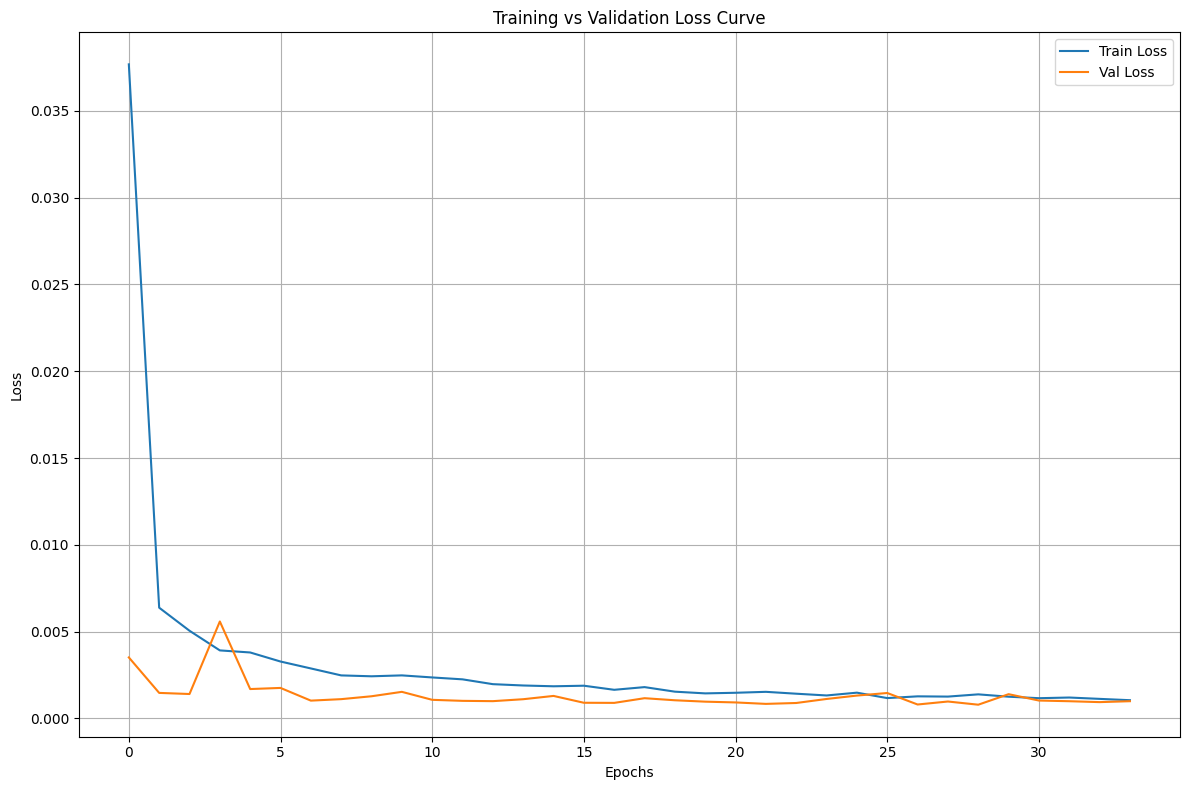

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Train_Val_LOSS.png')
plt.show()

In [28]:
# Predictions
y_pred_val = model.predict(X_val)  # shape (num_test_samples, 1)
y_pred_test = model.predict(X_test)  # shape (num_test_samples, 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [29]:
# To convert predictions back to original scale, we need to inverse-transform
# But scaler was fit on full feature set. So we need to reconstruct arrays.

def invert_scale(y_scaled, X_input, scaler, target_index=0):
    """
    y_scaled: scaled predictions, shape (num_samples, horizon)
    X_input: the corresponding input sequences (for context), shape (num_samples, lookback, n_features)
    scaler: fitted MinMaxScaler
    target_index: index of the Close price feature in original data
    """
    num_samples, horizon = y_scaled.shape
    n_features = X_input.shape[2]
    # We'll build a dummy array to invert scale (fill other features)
    dummy = np.zeros((num_samples * horizon, n_features))
    # For each sample and each horizon step, replicate the last known non-target features
    for i in range(num_samples):
        last_feats = X_input[i, -1, :]  # last time step features
        for h in range(horizon):
            dummy[i * horizon + h, :] = last_feats
        # replace the target column
        # e.g. for target_index = 0 (Close), set dummy[...,0] = y_pred
    # Actually simpler for horizon = 1:
    dummy[:, target_index] = y_scaled.flatten()
    inv = scaler.inverse_transform(dummy)
    # Extract only the target column
    return inv[:, target_index].reshape(num_samples, horizon)

y_val_inv = invert_scale(y_val, X_val, scaler, target_index=0)
y_val_pred_inv = invert_scale(y_pred_val, X_val, scaler, target_index=0)

y_test_inv = invert_scale(y_test, X_test, scaler, target_index=0)
y_test_pred_inv = invert_scale(y_pred_test, X_test, scaler, target_index=0)

y_val_pred_inv[-1], y_test_pred_inv[-1]

(array([760.48835439]), array([862.53353806]))

In [30]:
val_index = val_df.index[lookback : lookback + len(y_val_inv)]
test_index = test_df.index[lookback : lookback + len(y_test_inv)]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


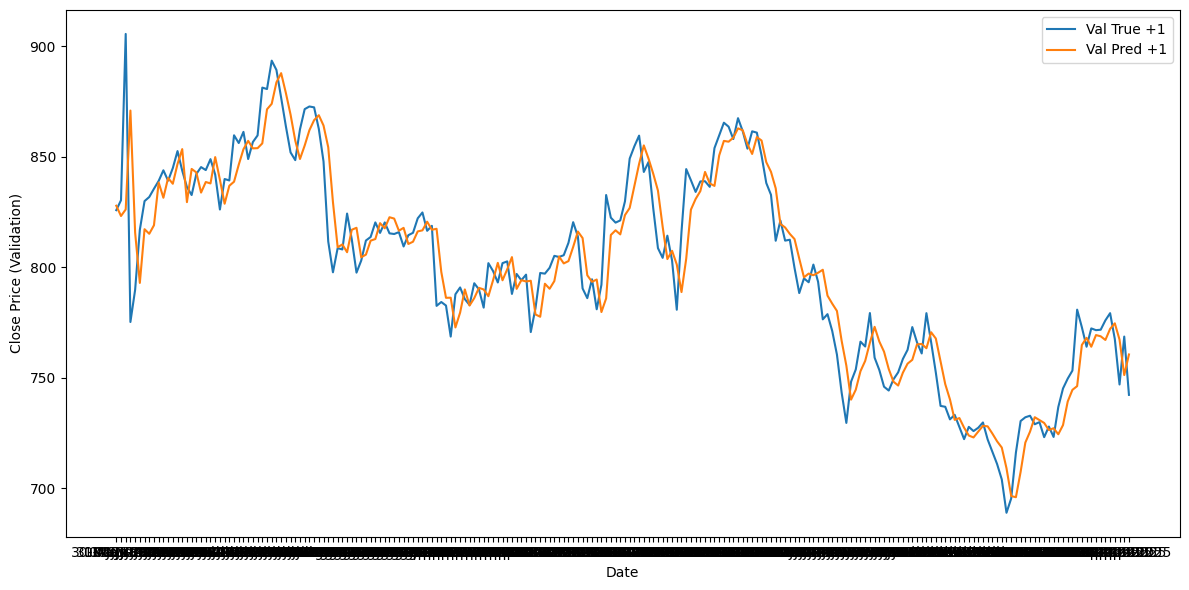

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


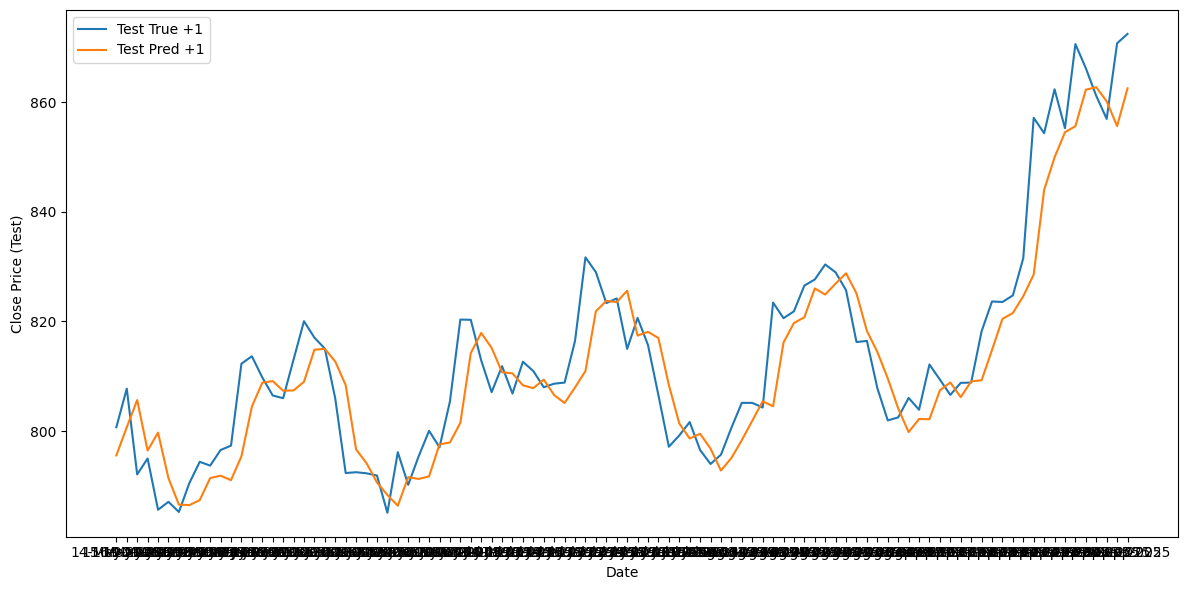

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(val_index, y_val_inv[:, 0], label="Val True +1")
plt.plot(val_index, y_val_pred_inv[:, 0], label="Val Pred +1")
plt.xlabel("Date")
plt.ylabel("Close Price (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig('Images/actual_pred_val1.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test_inv[:, 0], label="Test True +1")
plt.plot(test_index, y_test_pred_inv[:, 0], label="Test Pred +1")
plt.xlabel("Date")
plt.ylabel("Close Price (Test)")
plt.legend()
plt.tight_layout()
plt.savefig('Images/actual_pred_test1.png')
plt.show()


In [32]:
# Evaluation
# 7. Evaluate: e.g. RMSE, MAE per horizon or aggregated
from sklearn.metrics import mean_squared_error, mean_absolute_error
for h in range(horizon):
    mse_h = mean_squared_error(y_test_inv[:, h], y_test_pred_inv[:, h])
    mae_h = mean_absolute_error(y_test_inv[:, h], y_test_pred_inv[:, h])
    print(f"Horizon {h+1}: MSE = {mse_h:.4f}, MAE = {mae_h:.4f}")

# You can also compute aggregated metrics over all predictions
mse_all = mean_squared_error(y_test_inv.flatten(), y_test_pred_inv.flatten())
mae_all = mean_absolute_error(y_test_inv.flatten(), y_test_pred_inv.flatten())
print("Overall:", mse_all, mae_all)

Horizon 1: MSE = 61.3006, MAE = 5.8813
Overall: 61.30060186221441 5.881329616113582


### 1. Predicted vs Actual Scatter

A scatter plot is useful to see how close predictions are to true values (ideally points lie near the 45° line).

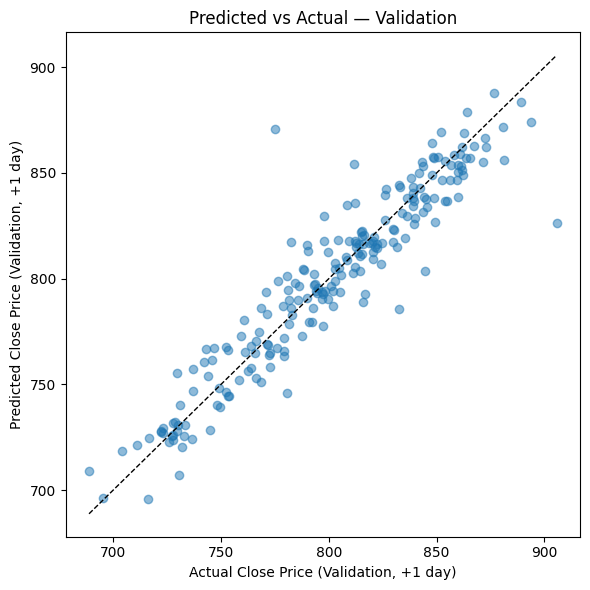

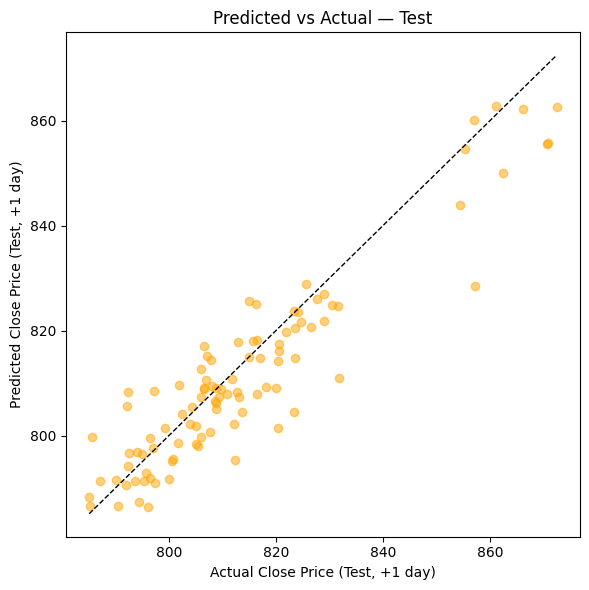

In [33]:
# Take horizon = 0 (first day ahead)
h = 0

# Validation scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val_inv[:, h], y_val_pred_inv[:, h], alpha=0.5)
lims = [
    np.min([y_val_inv[:, h].min(), y_val_pred_inv[:, h].min()]),
    np.max([y_val_inv[:, h].max(), y_val_pred_inv[:, h].max()])
]
plt.plot(lims, lims, 'k--', linewidth=1)  # 45° line
plt.xlabel("Actual Close Price (Validation, +1 day)")
plt.ylabel("Predicted Close Price (Validation, +1 day)")
plt.title("Predicted vs Actual — Validation")
plt.tight_layout()
plt.savefig('Images/Val_scatter_future.png')
plt.show()

# Test scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv[:, h], y_test_pred_inv[:, h], alpha=0.5, color='orange')
lims = [
    np.min([y_test_inv[:, h].min(), y_test_pred_inv[:, h].min()]),
    np.max([y_test_inv[:, h].max(), y_test_pred_inv[:, h].max()])
]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Actual Close Price (Test, +1 day)")
plt.ylabel("Predicted Close Price (Test, +1 day)")
plt.title("Predicted vs Actual — Test")
plt.tight_layout()
plt.savefig('Images/Test_scatter_future.png')
plt.show()


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def evaluate_true_pred(y_true, y_pred):
    """
    y_true, y_pred: arrays of shape (num_windows, horizon)
    Returns: a dict with per-horizon and aggregated metrics, including Bias (MBE)
    """
    results = {}
    num_windows, horizon = y_true.shape
    
    # Per-horizon metrics
    for h in range(horizon):
        mse_h = mean_squared_error(y_true[:, h], y_pred[:, h])
        mae_h = mean_absolute_error(y_true[:, h], y_pred[:, h])
        rmse_h = np.sqrt(mse_h)
        # Bias / MBE for that horizon
        bias_h = np.mean(y_true[:, h] - y_pred[:, h])
        results[f"horizon_{h+1}_mse"] = mse_h
        results[f"horizon_{h+1}_rmse"] = rmse_h
        results[f"horizon_{h+1}_mae"] = mae_h
        results[f"horizon_{h+1}_bias"] = bias_h
    
    # Aggregate metrics across all horizons
    all_true = y_true.flatten()
    all_pred = y_pred.flatten()
    mse_all = mean_squared_error(all_true, all_pred)
    mae_all = mean_absolute_error(all_true, all_pred)
    rmse_all = np.sqrt(mse_all)
    bias_all = np.mean(all_true - all_pred)
    results["all_mse"] = mse_all
    results["all_rmse"] = rmse_all
    results["all_mae"] = mae_all
    results["all_bias"] = bias_all
    
    return results

# Use it to compute for validation and test
eval_val = evaluate_true_pred(y_val_inv, y_val_pred_inv)
eval_test = evaluate_true_pred(y_test_inv, y_test_pred_inv)

# Build a table (DataFrame) with models (if you have multiple) and metrics
# Here I'll make a DataFrame for just your “SimpleRNN” model
metrics = {
    "Metric": [],
    "SimpleRNN_Validation": [],
    "SimpleRNN_Test": []
}

# Add each metric from eval_val / eval_test into the table
for metric_name, val in eval_val.items():
    metrics["Metric"].append(metric_name)
    metrics["SimpleRNN_Validation"].append(val)
    # For test, if the same metric exists
    metrics["SimpleRNN_Test"].append(eval_test.get(metric_name, np.nan))

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

metrics_path = os.path.join(output_dir, "SimpleRNN_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)

print(f"\n📁 Metrics saved to: {metrics_path}")



           Metric  SimpleRNN_Validation  SimpleRNN_Test
0   horizon_1_mse            238.769663       61.300602
1  horizon_1_rmse             15.452173        7.829470
2   horizon_1_mae             10.808491        5.881330
3  horizon_1_bias              0.352622        2.370383
4         all_mse            238.769663       61.300602
5        all_rmse             15.452173        7.829470
6         all_mae             10.808491        5.881330
7        all_bias              0.352622        2.370383

📁 Metrics saved to: output\SimpleRNN_metrics.csv


### 3. Use the evaluation to check generalization

Compare validation vs test metrics. If performance on test is similar to validation, your model generalizes well. If test is much worse, you might be overfitting.

Look at scatter plots: if points deviate strongly from the diagonal, errors are large.

Also look at prediction errors over time: plot residuals (predicted minus true) over the dates to see if errors have temporal patterns.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


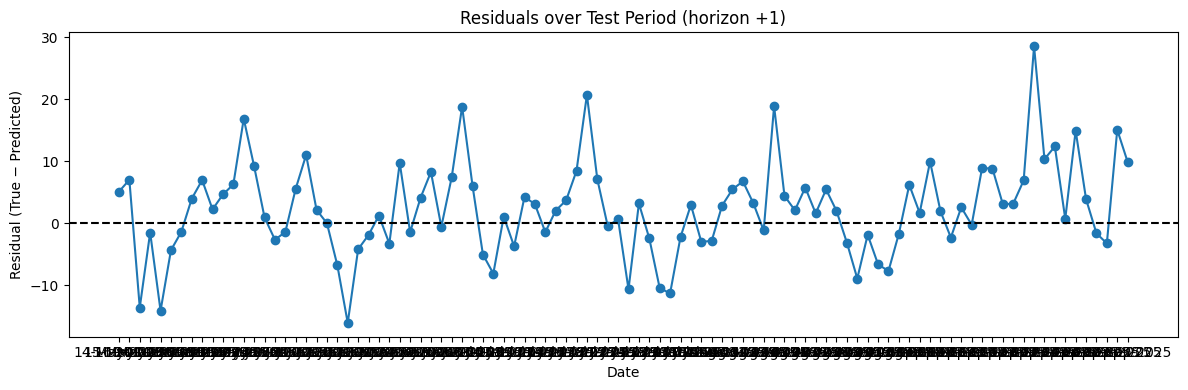

In [35]:
# Residual plot over test set (for first horizon)
residuals = y_test_inv[:, 0] - y_test_pred_inv[:, 0]
plt.figure(figsize=(12, 4))
plt.plot(test_index, residuals, marker='o', linestyle='-')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residual (True − Predicted)")
plt.title("Residuals over Test Period (horizon +1)")
plt.tight_layout()
plt.show()


In [36]:
bias = np.mean(residuals)
print("Bias (mean residual):", bias)


Bias (mean residual): 2.3703826249862123


The mean bias of approximately 2.37 indicates that, on average, your model's predictions are overestimating the actual close prices by this amount.
> Predicted values are 2.370 units less than the actual close prices.

> So, your model is slightly `overpredicting` the target values.



## Next steps to improvise
- **Feature Engineering**:

> - Incorporate additional features that might influence the close price, such as trading volume, market sentiment indicators, or macroeconomic factors.
> - Ensure that your features are scaled appropriately and that no important variables are omitted.

- **Model Complexity**:

> - Experiment with more complex models like Long Short-Term Memory (LSTM) networks, which are better suited for capturing temporal dependencies in sequential data.
> - Consider ensemble methods that combine multiple models to reduce bias and variance.

- **Bias Correction Techniques**:

> - Implement post-processing techniques to adjust for the observed bias, ensuring more accurate predictions.
> - Regularly evaluate your model's performance on unseen data to detect and correct any emerging biases.